<a href="https://colab.research.google.com/github/niteeshchandrav/LGMVIP-DATA-SCIENCE/blob/main/Task_2_Stock_Market_Prediction_And_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TASK-2 Stock Market Prediction And Forecasting Using Stacked LSTM

### Import the necessary libraries 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:,1:2].values

In [4]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [5]:
data_close = dataset_train['Close']

In [6]:
data_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

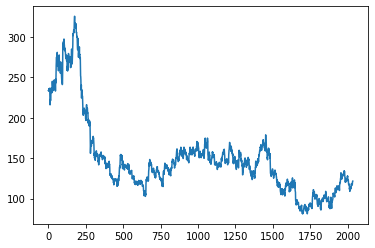

In [7]:
plt.plot(data_close)

###### Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transfer our values between 0 and 1

### Data Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1,1))

In [9]:
data_close.shape

(2035, 1)

In [10]:
print(data_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


### Train and Test Split 

In [11]:
training_size = int(len(data_close) * 0.75)
test_size = len(data_close) - training_size
train_data, test_data = data_close[0:training_size,:], data_close[training_size:len(data_close),:1]

In [12]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [13]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [14]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [15]:
#create the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
23/23 [==============================] - 10s 225ms/step - loss: 0.0239 - val_loss: 0.0090
Epoch 2/100
23/23 [==============================] - 4s 171ms/step - loss: 0.0028 - val_loss: 9.3521e-04
Epoch 3/100
23/23 [==============================] - 4s 168ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/100
23/23 [==============================] - 4s 170ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
23/23 [==============================] - 4s 166ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
23/23 [==============================] - 4s 167ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
23/23 [==============================] - 4s 170ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 4s 168ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/100
23/23 [==============================] - 4s 168ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/100
23/23 [==============================] - 4s 166ms/step - loss: 0.0012 - v

In [18]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [19]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [20]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

163.56052332020334

In [21]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

106.14451777671103

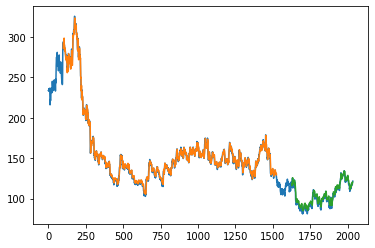

In [22]:
# plotting 
#shift train prediction for plotting
look_back = 100
trainPredictionPlot = np.empty_like(data_close)
trainPredictionPlot[:,:] = np.nan
trainPredictionPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test prediction for plotting
testPredictionPlot = np.empty_like(data_close)
testPredictionPlot[:,:] = np.nan
testPredictionPlot[len(train_predict) + (look_back * 2)+1:len(data_close)-1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(data_close))
plt.plot(trainPredictionPlot)
plt.plot(testPredictionPlot)
plt.show()


##### Predict the next 30 days Stock Price 

In [23]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [24]:
x_input = test = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [25]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [26]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input= x_input.reshape((1,n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input= x_input.reshape((1,n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

[0.16931319]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [27]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [28]:
df3 = data_close.tolist()
df3.extend(lst_output)

In [29]:
len(data_close)

2035

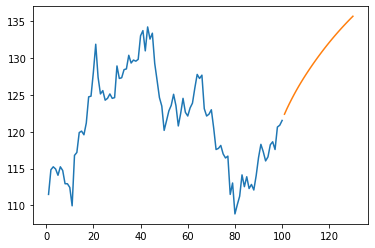

In [30]:
plt.plot(day_new, scaler.inverse_transform(data_close[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
